В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

data_1 = pd.read_csv('~/bank-customer-churn-prediction-dlu-course-c-2/train.csv')

In [3]:
from process_bank_churn import preprocess_data 

In [4]:
data = preprocess_data(data_1)

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
from sklearn.metrics import roc_curve, auc

In [6]:
X_train = data['X_train']
y_train = data['train_targets']

In [7]:
X_val = data['X_val']
y_val = data['val_targets']

In [8]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [40]:
def compute_auroc(model, inputs, targets, name=''):
  
  y_pred_proba = model.predict_proba(inputs)[:, 1]

  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC {model} for {name}: {roc_auc:.4f}')

In [41]:
compute_auroc(knn, X_train, y_train, 'Training')
compute_auroc(knn, X_val, y_val, 'Validation')

AUROC KNeighborsClassifier() for Training: 0.9559
AUROC KNeighborsClassifier() for Validation: 0.8525


модель є задовільною

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [11]:
params_knn = {'n_neighbors': np.arange(1, 25)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [12]:
knn_best = knn_gs.best_estimator_
print(knn_gs.best_params_, knn_gs.best_score_)

{'n_neighbors': 9} 0.8670833333333334


In [43]:
compute_auroc(knn_best, X_train, y_train, 'Training')
compute_auroc(knn_best, X_val, y_val, 'Validation')

AUROC KNeighborsClassifier(n_neighbors=9) for Training: 0.9407
AUROC KNeighborsClassifier(n_neighbors=9) for Validation: 0.8807


порівняно з попереднім завданням модель не змінилась, так як за замовчуванням значення cv також дорівнює 5, тобто не відбулось ніяких змін 

модель є гіршою за дерево з попереднього дз

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
params = dict()
params['max_depth'] = np.arange(1, 22, 2)
params['max_leaf_nodes'] = np.arange(2, 11, 1)

In [17]:
model = DecisionTreeClassifier(random_state=42)

In [18]:
tree_model = GridSearchCV(
    model,
    params,
    cv = 3,
    scoring='roc_auc',
    verbose=3
)

In [19]:
%time
tree_model.fit(X_train, y_train)

CPU times: user 10 μs, sys: 1 μs, total: 11 μs
Wall time: 20.3 μs
Fitting 3 folds for each of 99 candidates, totalling 297 fits
[CV 1/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.738 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.743 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.754 total time=   0.0s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=3;, score=0.738 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=3;, score=0.743 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=3;, score=0.754 total time=   0.0s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=4;, score=0.738 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=4;, score=0.743 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=4;, score=0.754 total time=   0.0s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=5;, score=0.738 total time=   0.0s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=5;, score=0.743 

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
                         'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='roc_auc', verbose=3)

In [21]:
dt_best =  tree_model.best_params_

In [23]:
dt_est =  tree_model.best_estimator_

In [22]:
print(dt_best)

{'max_depth': 5, 'max_leaf_nodes': 10}


In [44]:
compute_auroc(dt_est, X_train, y_train, 'Training')
compute_auroc(dt_est, X_val, y_val, 'Validation')

AUROC DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=42) for Training: 0.9015
AUROC DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, random_state=42) for Validation: 0.9002


Ця модель є кращою за зроблену вручну

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [27]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [30]:
r_search = RandomizedSearchCV(
    model,
    params_dt,
    n_iter = 40,
    cv=3,
    scoring='roc_auc',
    verbose=3,
    refit=True
)

In [31]:
%time
r_search.fit(X_train, y_train)

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 5.25 μs
Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END criterion=entropy, max_depth=11, max_features=None, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2, splitter=random;, score=0.738 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=11, max_features=None, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2, splitter=random;, score=0.752 total time=   0.0s
[CV 3/3] END criterion=entropy, max_depth=11, max_features=None, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=2, splitter=random;, score=0.738 total time=   0.0s
[CV 1/3] END criterion=entropy, max_depth=3, max_features=log2, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=20, splitter=random;, score=0.690 total time=   0.0s
[CV 2/3] END criterion=entropy, max_depth=3, max_features=log2, max_leaf_nodes=9, min_samples_leaf=2, min_samples_split=20, splitter=random;, score=0.686 total time=   0.0s
[CV 3

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   scoring='roc_auc', verbose=3)

In [32]:
dt_random_search_best = r_search.best_estimator_

In [45]:
compute_auroc(dt_random_search_best, X_train, y_train, 'Training')
compute_auroc(dt_random_search_best, X_val, y_val, 'Validation')

AUROC DecisionTreeClassifier(max_depth=13, max_leaf_nodes=16, min_samples_leaf=4,
                       min_samples_split=20, random_state=42) for Training: 0.9145
AUROC DecisionTreeClassifier(max_depth=13, max_leaf_nodes=16, min_samples_leaf=4,
                       min_samples_split=20, random_state=42) for Validation: 0.9136


Ця модель виявилася найкращою з усіх протестованих у цьому дз. ЇЇ точність на тренувальній та валідаційній вибірці є майже однаковою

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [61]:
test_df = pd.read_csv('~/bank-customer-churn-prediction-dlu-course-c-2/test.csv')

In [62]:
test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [47]:
from process_bank_churn import preprocess_new_data 

In [80]:
new_data = preprocess_new_data(test_df, data['input_cols'], data['scaler'], data['encoder'], scale_numeric=True)

In [48]:
sample_submission_df = pd.read_csv("~/bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv")

In [81]:
new_data.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.984482,0.365155,0.214286,0.2,0.696265,0.000000,1.0,1.0,0.789477,0.0,1.0,0.0,0.0,1.0
1,0.987856,0.286396,0.375000,0.5,0.000000,0.333333,1.0,1.0,0.337131,1.0,0.0,0.0,0.0,1.0
2,0.993017,0.656325,0.446429,0.8,0.000000,0.333333,1.0,0.0,0.783859,1.0,0.0,0.0,0.0,1.0
3,0.997849,0.682578,0.482143,0.3,0.000000,0.000000,1.0,1.0,0.834571,0.0,0.0,1.0,0.0,1.0
4,0.989270,0.384248,0.446429,0.8,0.000000,0.333333,1.0,1.0,0.718421,0.0,0.0,1.0,0.0,1.0


In [82]:
sample_submission_df["Exited"] = dt_random_search_best.predict_proba(new_data)[:,1]

In [87]:
sample_submission_df.to_csv("submission_log_reg_2.csv", index=False, float_format="%.3f")

In [88]:
submission_log_reg = pd.read_csv("~/Завантаження/submission_log_reg_2.csv")

In [89]:
submission_log_reg.head(25)

,id,Exited
0,15000,0.264
1,15001,0.021
2,15002,0.021
3,15003,0.749
4,15004,0.021
5,15005,0.205
6,15006,0.021
7,15007,0.021
8,15008,0.021
9,15009,0.021


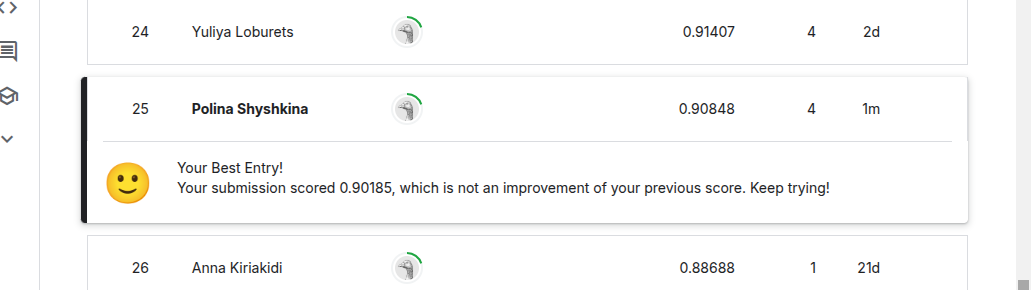

на цей раз модель спрацювала гірше ніж у минулий